# Problem statement

The aim is to develop an algorithm to predict whether a tweet is about a real disaster or not.

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm

import re
import string

import nltk
from nltk.corpus import stopwords
stop_words = stopwords.words('english')


import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding
from tensorflow.keras.initializers import Constant
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


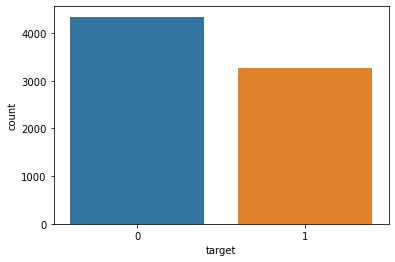

In [3]:
ax = sns.countplot(x="target", data=df)

There is no class imbalance in the distribution of target variable.

# Data Clensing

We are using custom functions to perform the following tasks. Cleaning up the data for modeling should be carried out carefully and with the help of subject matter experts, if possible. This cleaning is done completely based on observation, and can not be considered as a generic preprocessing step for all the NLP tasks. This preprocessing function ensures:

* Removing urls from tweet
* Removing html tags
* Removing punctuations
* Removing stopwords
* Removing emoji
* Replacing misspelled words (For using pretrained word embeddings)

In [4]:
def clean_text(text):
    
    sw = stopwords.words('english')
    
    text = re.sub(r"[^a-zA-Z?.!,¿]+", " ", text) # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")

    text = re.sub(r"http\S+", "",text) #Removing URLs 
    #text = re.sub(r"http", "",text)
    
    html=re.compile(r'<.*?>') 
    
    text = html.sub(r'',text) #Removing html tags
    
    punctuations = '@#!?+&*[]-%.:/();$=><|{}^' + "'`" + '_'
    for p in punctuations:
        text = text.replace(p,'') #Removing punctuations
        
    text = [word.lower() for word in text.split() if word.lower() not in sw]
    
    text = " ".join(text) #removing stopwords
    
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text) #Removing emojis
    
    return text


In [5]:
mispell_dict = {"ain't": "is not", "aren't": "are not","can't": "cannot", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have", 'colour': 'color', 'centre': 'center', 'favourite': 'favorite', 'travelling': 'traveling', 'counselling': 'counseling', 'theatre': 'theater', 'cancelled': 'canceled', 'labour': 'labor', 'organisation': 'organization', 'wwii': 'world war 2', 'citicise': 'criticize', 'youtu ': 'youtube ', 'Qoura': 'Quora', 'sallary': 'salary', 'Whta': 'What', 'narcisist': 'narcissist', 'howdo': 'how do', 'whatare': 'what are', 'howcan': 'how can', 'howmuch': 'how much', 'howmany': 'how many', 'whydo': 'why do', 'doI': 'do I', 'theBest': 'the best', 'howdoes': 'how does', 'mastrubation': 'masturbation', 'mastrubate': 'masturbate', "mastrubating": 'masturbating', 'pennis': 'penis', 'Etherium': 'Ethereum', 'narcissit': 'narcissist', 'bigdata': 'big data', '2k17': '2017', '2k18': '2018', 'qouta': 'quota', 'exboyfriend': 'ex boyfriend', 'airhostess': 'air hostess', "whst": 'what', 'watsapp': 'whatsapp', 'demonitisation': 'demonetization', 'demonitization': 'demonetization', 'demonetisation': 'demonetization'}

Reference - https://www.kaggle.com/mlwhiz/textcnn-pytorch-and-keras

In [6]:
def _get_mispell(mispell_dict):
    mispell_re = re.compile('(%s)' % '|'.join(mispell_dict.keys()))
    return mispell_dict, mispell_re

mispellings, mispellings_re = _get_mispell(mispell_dict)
def replace_misspell(text):
    def replace(match):
        return mispellings[match.group(0)]
    return mispellings_re.sub(replace, text)

In [7]:
df['text'] = df['text'].str.lower()
df['text'] = df['text'].apply(lambda x: clean_text(x))
df['text'] = df['text'].apply(lambda x: replace_misspell(x))

 
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,deeds reason earthquake may allah forgive us,1
1,4,NaN,NaN,forest fire near la ronge sask canada,1
2,5,NaN,NaN,residents asked shelter place notified officer...,1
3,6,NaN,NaN,", people receive wildfires evacuation orders c...",1
4,7,NaN,NaN,got sent photo ruby alaska smoke wildfires pou...,1


Now,Like any supervised machine learning problem,we are spliting the dataset to train,test and validation sets.

In [8]:
x_train,x_test,y_train,y_test=train_test_split(df['text'].values,df['target'].values,test_size=0.2,random_state=123)
x_train,x_val,y_train,y_val=train_test_split(x_train,y_train,test_size=0.1,random_state=123)

# Tokenization

References
1. https://www.analyticsvidhya.com/blog/2020/05/what-is-tokenization-nlp/
2. https://www.analyticsvidhya.com/blog/2019/07/how-get-started-nlp-6-unique-ways-perform-tokenization/



Tokenization is a common task in NLP. This is the process of spliting of sentences to basic input unit. Ultimate aim of tokenization is to built a vocabulary. Vocabulary is the unique set of all the tokens. Tokenization can be be performed on:

* character level
* subword level
* word level

**Word Tokenization** is the most commonly used tokenization algorithm, this is because of the availabity of pretrained word embeddings. Pretrained word embeddings are trained on a large volume of corpous, hence large vocabulary.

A problem with word tokenization is that the presence of **OOV**(Out of vocabulary) words. OOV words refer to the new words which are encountered at testing. These new words do not exist in the vocabulary. Hence, these methods fail in handling OOV words. One way to handle OOV words is to form the vocabulary with the Top K Frequent Words and replace the rare words in training data with unknown tokens (UNK). This helps the model to learn the representation of OOV words in terms of UNK tokens. So, during test time, any word that is not present in the vocabulary will be mapped to a UNK token. This is how we can tackle the problem of OOV in word tokenizers. The problem with this approach is that the entire information of the word is lost as we are mapping OOV to UNK tokens. The structure of the word might be helpful in representing the word accurately. And another issue is that every OOV word gets the same representation.

**character Tokenization** splits a piece of text into a set of characters. Character level tokenization will have fixed vocabulary (26 characters + digits + special characters). The inputs increases verymuch and it will be challenging to learn the meaning of words from the character level tokens.

**Subword Tokenization** splits the piece of text into subwords (or n-gram characters). Transformed based models rely on Subword Tokenization algorithms for preparing vocabulary. There are different types of subword tokenization such as **BPE (Byte Pair Encoding)** .

We will be using word level tokenization, Using **Tensorflow Keras Tokenizer API**. <br> 

Ref - https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer

In [9]:
tokenizer = Tokenizer(num_words=None)
tokenizer.fit_on_texts(x_train)

word_index = tokenizer.word_index
num_words = len(tokenizer.word_index) + 1

We bulit dictionary based on tokens in training set. We can perform a variety of preprocessing using the tokenizer class, without writing custom functions. We will analyse the model performance based on this limited vocabulary, with OOV tokens in test and validation sets.

### Converting text to sequences

Tokenizer class maps the tokens to unique numbers. In a sequential learning problem, every sentence is inputed as sequence of numbers. The prebuilt function 'texts_to_sequences' in tensorflow helps to convert sentences to sequence of numbers. We all know that sentences can be of variable length. We use padding, to make sentence constant length. We add 0's either before or after every sequence, to match the maximum sequence length. 

In [10]:
train_sequences = tokenizer.texts_to_sequences(x_train)
train_padded = tf.keras.preprocessing.sequence.pad_sequences(train_sequences,padding='post')

max_len = len(train_padded[0])

validation_sequences = tokenizer.texts_to_sequences(x_val)
validation_padded = tf.keras.preprocessing.sequence.pad_sequences(validation_sequences,padding='post',maxlen=max_len)

test_sequences = tokenizer.texts_to_sequences(x_test)
test_padded = tf.keras.preprocessing.sequence.pad_sequences(test_sequences,padding='post',maxlen=max_len)

## Model Using tf.Keras

## Embedding layer

Transfers one-hot word vectors to dense vectors. One way is to use pre-defined embedding layers such as word2vec or glove, which are calculated on a huge amount of data such as Wikepedia. Another way is to calculate the embedding layer while training. Here the embedding vectors change after each timestep of training. For calculating training embedding, we can either use pre-defined embedding values initially or train from scratch.

We will built our first model training on the sequences we generated earlier.

In [11]:
model = tf.keras.Sequential([
tf.keras.layers.Embedding(num_words, 100,mask_zero=True),
#tf.keras.layers.LSTM(64),
tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,recurrent_dropout=0.1)),
tf.keras.layers.Dense(64, activation='relu'),
tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.Adam(1e-4),metrics=['accuracy'])

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         1765200   
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               84480     
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 1,858,001
Trainable params: 1,858,001
Non-trainable params: 0
_________________________________________________________________


In [13]:
num_epochs = 30

In [14]:
history = model.fit(train_padded, y_train, epochs=num_epochs,validation_data=(validation_padded, y_val), verbose=2)

Epoch 1/30
172/172 - 12s - loss: 0.6878 - accuracy: 0.5641 - val_loss: 0.6767 - val_accuracy: 0.5961
Epoch 2/30
172/172 - 11s - loss: 0.5767 - accuracy: 0.7490 - val_loss: 0.5185 - val_accuracy: 0.7915
Epoch 3/30
172/172 - 12s - loss: 0.3257 - accuracy: 0.8878 - val_loss: 0.5046 - val_accuracy: 0.7964
Epoch 4/30
172/172 - 12s - loss: 0.1955 - accuracy: 0.9383 - val_loss: 0.5818 - val_accuracy: 0.7750
Epoch 5/30
172/172 - 12s - loss: 0.1219 - accuracy: 0.9637 - val_loss: 0.7032 - val_accuracy: 0.7652
Epoch 6/30
172/172 - 12s - loss: 0.0807 - accuracy: 0.9763 - val_loss: 0.7994 - val_accuracy: 0.7652
Epoch 7/30
172/172 - 11s - loss: 0.0584 - accuracy: 0.9849 - val_loss: 0.9516 - val_accuracy: 0.7586
Epoch 8/30
172/172 - 12s - loss: 0.0472 - accuracy: 0.9892 - val_loss: 1.0242 - val_accuracy: 0.7570
Epoch 9/30
172/172 - 12s - loss: 0.0398 - accuracy: 0.9907 - val_loss: 1.1385 - val_accuracy: 0.7373
Epoch 10/30
172/172 - 12s - loss: 0.0322 - accuracy: 0.9934 - val_loss: 1.1955 - val_accura

In [15]:
y_pred = model.predict_classes(test_padded)

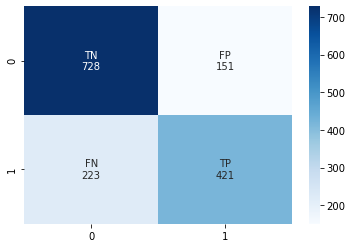

In [16]:
cnf_matrix = confusion_matrix(y_test,y_pred)
group_names = ['TN','FP','FN','TP']
group_counts = ["{0:0.0f}".format(value) for value in cnf_matrix.flatten()]
labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cnf_matrix, annot=labels, fmt='', cmap='Blues');

In [17]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.77      0.83      0.80       879
           1       0.74      0.65      0.69       644

    accuracy                           0.75      1523
   macro avg       0.75      0.74      0.74      1523
weighted avg       0.75      0.75      0.75      1523



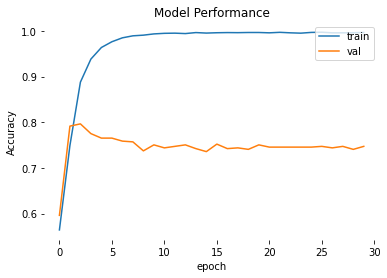

In [18]:
#history.history['accuracy']
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Performance')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.box(False)
plt.show()

We can observe we are not using the best model. We can use tensorflow callback method to ensure we get the best model.

## Using Pre-trained Word Embeddings

we will load glove embeddings, pretrained on wikepedia data.

In [19]:
embedding_dict={}
with open('../input/glove6b100dtxt/glove.6B.100d.txt','r') as f:
    for line in f:
        values=line.split()
        word = values[0]
        vectors=np.asarray(values[1:],'float32')
        embedding_dict[word]=vectors
f.close()

Now, we will create an embedding matrix.

In [20]:
words_na = []
embedding_matrix = np.zeros((num_words,100))
word_index = tokenizer.word_index
for word,i in tqdm(word_index.items()):
    if i > num_words:
        continue
    emb_vec=embedding_dict.get(word)
    
    if emb_vec is None:
        
        
        words_na.append(word)
    
    elif emb_vec is not None:
        embedding_matrix[i]=emb_vec

100%|██████████| 17651/17651 [00:00<00:00, 423839.04it/s]


In [21]:
print("Out of vocabulory words:",len(words_na))

Out of vocabulory words: 6572


In [22]:
print("% of Out of vocabulory words:",(len(words_na)/num_words)*100)

% of Out of vocabulory words: 37.23090867890324


In [23]:
model2 = tf.keras.Sequential([
tf.keras.layers.Embedding(num_words,100,embeddings_initializer=Constant(embedding_matrix),trainable=False),
#tf.keras.layers.LSTM(64),
tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
tf.keras.layers.Dense(64, activation='relu'),
tf.keras.layers.Dense(1, activation='sigmoid')
])

model2.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.Adam(1e-4),metrics=['accuracy'])

In [24]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 100)         1765200   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               84480     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 1,858,001
Trainable params: 92,801
Non-trainable params: 1,765,200
_________________________________________________________________


In [25]:
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0,restore_best_weights=True, mode='auto')
history = model2.fit(train_padded, y_train, epochs=num_epochs,validation_data=(validation_padded, y_val), verbose=2,callbacks=[earlystop])

Epoch 1/30
172/172 - 5s - loss: 0.6117 - accuracy: 0.7030 - val_loss: 0.5129 - val_accuracy: 0.7734
Epoch 2/30
172/172 - 4s - loss: 0.4638 - accuracy: 0.7946 - val_loss: 0.4814 - val_accuracy: 0.7800
Epoch 3/30
172/172 - 4s - loss: 0.4362 - accuracy: 0.8126 - val_loss: 0.4649 - val_accuracy: 0.7915
Epoch 4/30
172/172 - 4s - loss: 0.4240 - accuracy: 0.8174 - val_loss: 0.4569 - val_accuracy: 0.7931
Epoch 5/30
172/172 - 4s - loss: 0.4159 - accuracy: 0.8172 - val_loss: 0.4510 - val_accuracy: 0.8046
Epoch 6/30
172/172 - 4s - loss: 0.4068 - accuracy: 0.8228 - val_loss: 0.4567 - val_accuracy: 0.7964
Epoch 7/30
172/172 - 4s - loss: 0.4014 - accuracy: 0.8311 - val_loss: 0.4493 - val_accuracy: 0.8046
Epoch 8/30
172/172 - 4s - loss: 0.3974 - accuracy: 0.8285 - val_loss: 0.4431 - val_accuracy: 0.8062
Epoch 9/30
172/172 - 4s - loss: 0.3907 - accuracy: 0.8300 - val_loss: 0.4392 - val_accuracy: 0.8030
Epoch 10/30
172/172 - 4s - loss: 0.3860 - accuracy: 0.8332 - val_loss: 0.4354 - val_accuracy: 0.8079

In [26]:
y_pred = model2.predict_classes(test_padded)

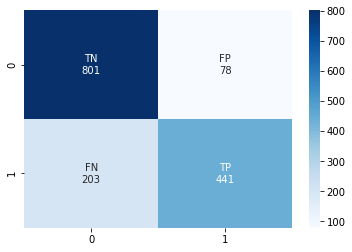

In [27]:
cnf_matrix = confusion_matrix(y_test,y_pred)
group_names = ['TN','FP','FN','TP']
group_counts = ["{0:0.0f}".format(value) for value in cnf_matrix.flatten()]
labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cnf_matrix, annot=labels, fmt='', cmap='Blues');

In [28]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.80      0.91      0.85       879
           1       0.85      0.68      0.76       644

    accuracy                           0.82      1523
   macro avg       0.82      0.80      0.80      1523
weighted avg       0.82      0.82      0.81      1523



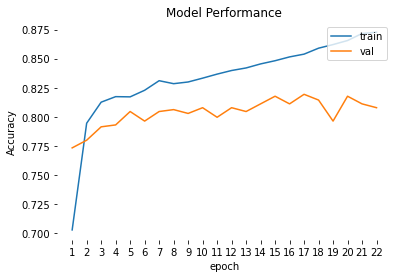

In [29]:
epochs = range(1,len(history.history['loss'])+1)
plt.plot(epochs,history.history['accuracy'])
plt.plot(epochs,history.history['val_accuracy'])
plt.title('Model Performance')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.xticks(epochs)
plt.legend(['train', 'val'], loc='upper right')
plt.box(False)
plt.show()

We can see the improvement in accuracy.

# Submission

In [30]:
df_sub = pd.read_csv('../input/nlp-getting-started/test.csv')

In [31]:
df_sub['text'] = df_sub['text'].str.lower()
df_sub['text'] = df_sub['text'].apply(lambda x: clean_text(x))
df_sub['text'] = df_sub['text'].apply(lambda x: replace_misspell(x))

 
df_sub.head()

,id,keyword,location,text
0,0,NaN,NaN,happened terrible car crash
1,2,NaN,NaN,"heard earthquake different cities, stay safe e..."
2,3,NaN,NaN,"forest fire spot pond, geese fleeing across st..."
3,9,NaN,NaN,apocalypse lighting spokane wildfires
4,11,NaN,NaN,typhoon soudelor kills china taiwan


In [32]:
X_sub =  df_sub['text'].values
sub_sequences = tokenizer.texts_to_sequences(X_sub)
sub_padded = tf.keras.preprocessing.sequence.pad_sequences(sub_sequences,padding='post',maxlen=max_len)

In [33]:
y_pred = model2.predict_classes(sub_padded)
df_output = pd.DataFrame()
df_output['id'] = df_sub['id']
df_output['target'] =[x.item() for x in list(y_pred)]

In [34]:
df_output.to_csv('submission.csv',index=False)

# End Notes

This notebook is a beginer level approach for solving a NLP task. The model is not perfect, and there is scope for experiments like modifying model architecture,performing hyper parameter tuning, using different word embeddings etc. Also, there are other models, including transformer based models like BERT,that can be used for this task.